In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 2. Exploratory Data Analysis

First, we will load in the diabetes data and check out some of the data types. Immediately, we see that some of the features that should be numerical (Diabetes_Number and Obesity_Number) are strings instead. Exploring further, we see that sometimes they have values like "No Data" or "Suppressed" in them, so we drop these. We can check to see what the string values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`

In [2]:
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv')
diabetes.dtypes

County                                                                               object
State                                                                                object
CountyFIPS                                                                            int64
Diabetes_Number                                                                      object
Obesity_Number                                                                       object
                                                                                     ...   
sex and age_total population_18 years and over_female                                 int64
sex and age_total population_18 years and over_sex ratio (males per 100 females)    float64
sex and age_total population_65 years and over_1                                      int64
sex and age_total population_65 years and over_male                                   int64
sex and age_total population_65 years and over_female                           

In [3]:
# Return rows where "Obesity_Number" is non-numeric and get the unique values of these rows
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 

# Do the same but with "Diabetes Number"
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['No Data']
['Suppressed']


Next, we filter out these observations from the dataset and convert Physical_Inactivity_Number to an integer.

In [4]:
# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int)

# Physical Inactivity
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int)

# Diabetes
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int)

### 2.1 Joint Distribution of Obesity/Physical Inactivity v. Diabetes

We have lots of different features that relate to the demographics of each county, but two that stand out are Obesity_Number and Physical_Inactivity_Number. These two features likely proxy for many of the other ones, and might be strong predictors of diabetes or pre-diabetes. Below, we visualize the joint distribution of these two features against Diabetes_Number.

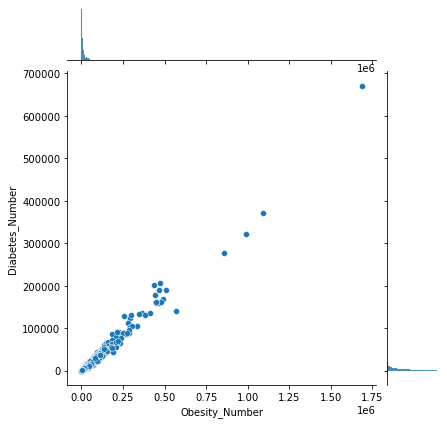

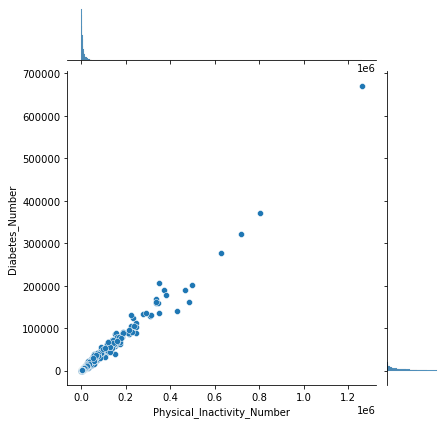

In [5]:
sns.jointplot(data=diabetes, x="Obesity_Number", y="Diabetes_Number")
sns.jointplot(data=diabetes, x="Physical_Inactivity_Number", y="Diabetes_Number")

They both have highly positively correlated relationships with Diabetes_Number! There might be a problem here though. Different counties in the U.S. have very different population sizes. If we used these as predictors, we might just be predicting county population size rather than prevalence of diabetes.

### 2.2 Correlation Plots

Let's investigate this first. We visualize a heatmap to see the pairwise correlations of the 

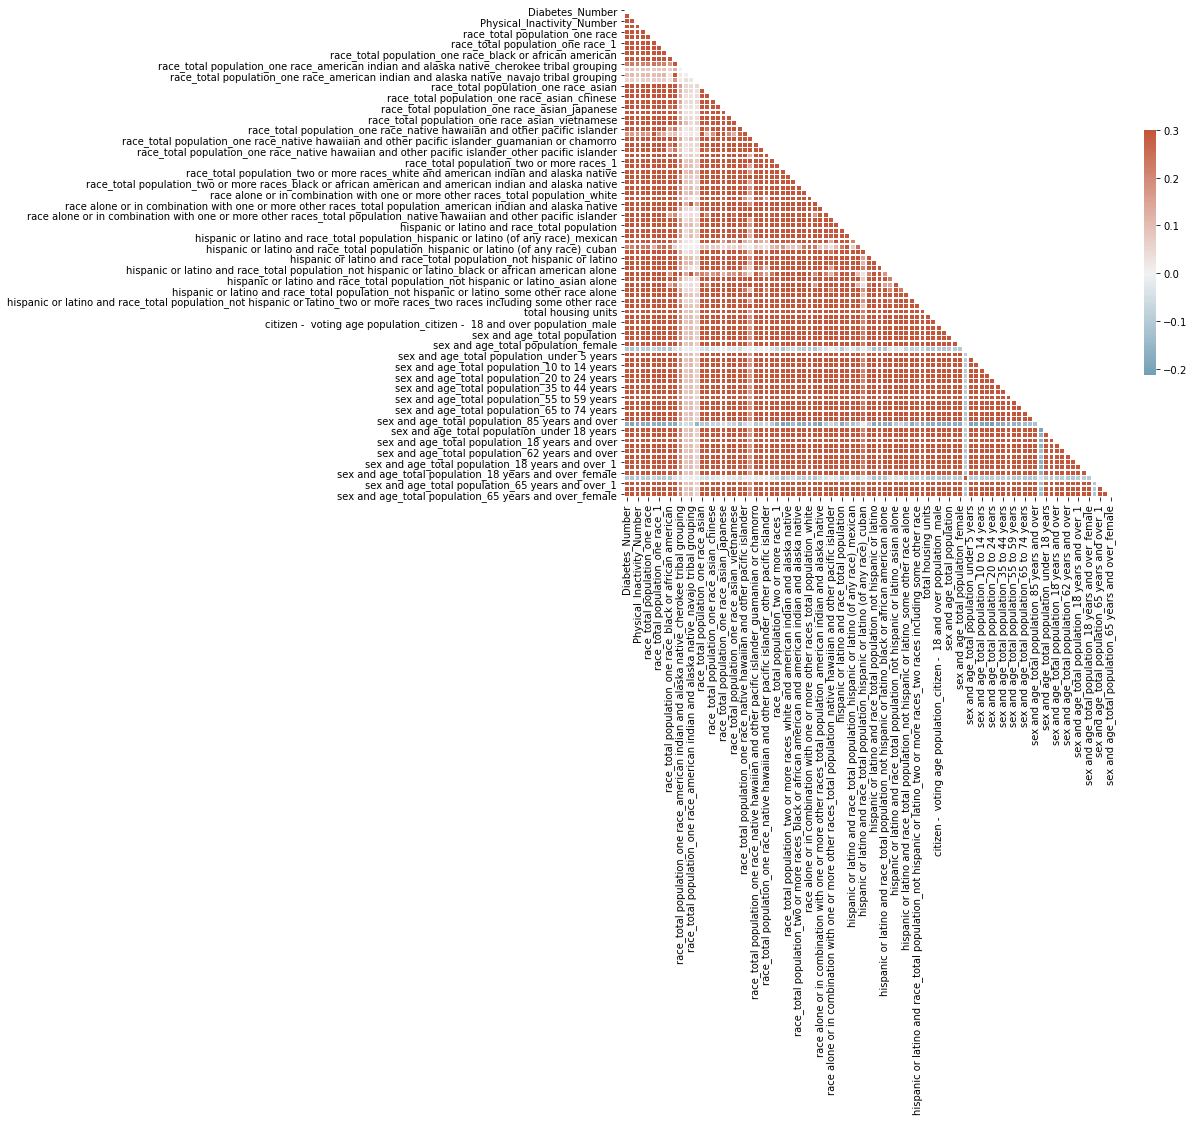

In [6]:
# Compute the correlation matrix
corr = diabetes.drop(['CountyFIPS'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This plot isn't too informative - most features have around a .3 correlation with each other. What if we scaled Diabetes_Number, Obesity_Number, and Physical_Inactivity_Number by county population?

In [7]:
diabetes['diabetes_num_per_capita'] = diabetes['Diabetes_Number'] / diabetes['race_total population']
diabetes['obesity_num_per_capita'] = diabetes['Obesity_Number'] / diabetes['Obesity_Number'] / diabetes['race_total population']
diabetes['physical_inactivity_num_per_capita'] = diabetes['Physical_Inactivity_Number'] / diabetes['race_total population']

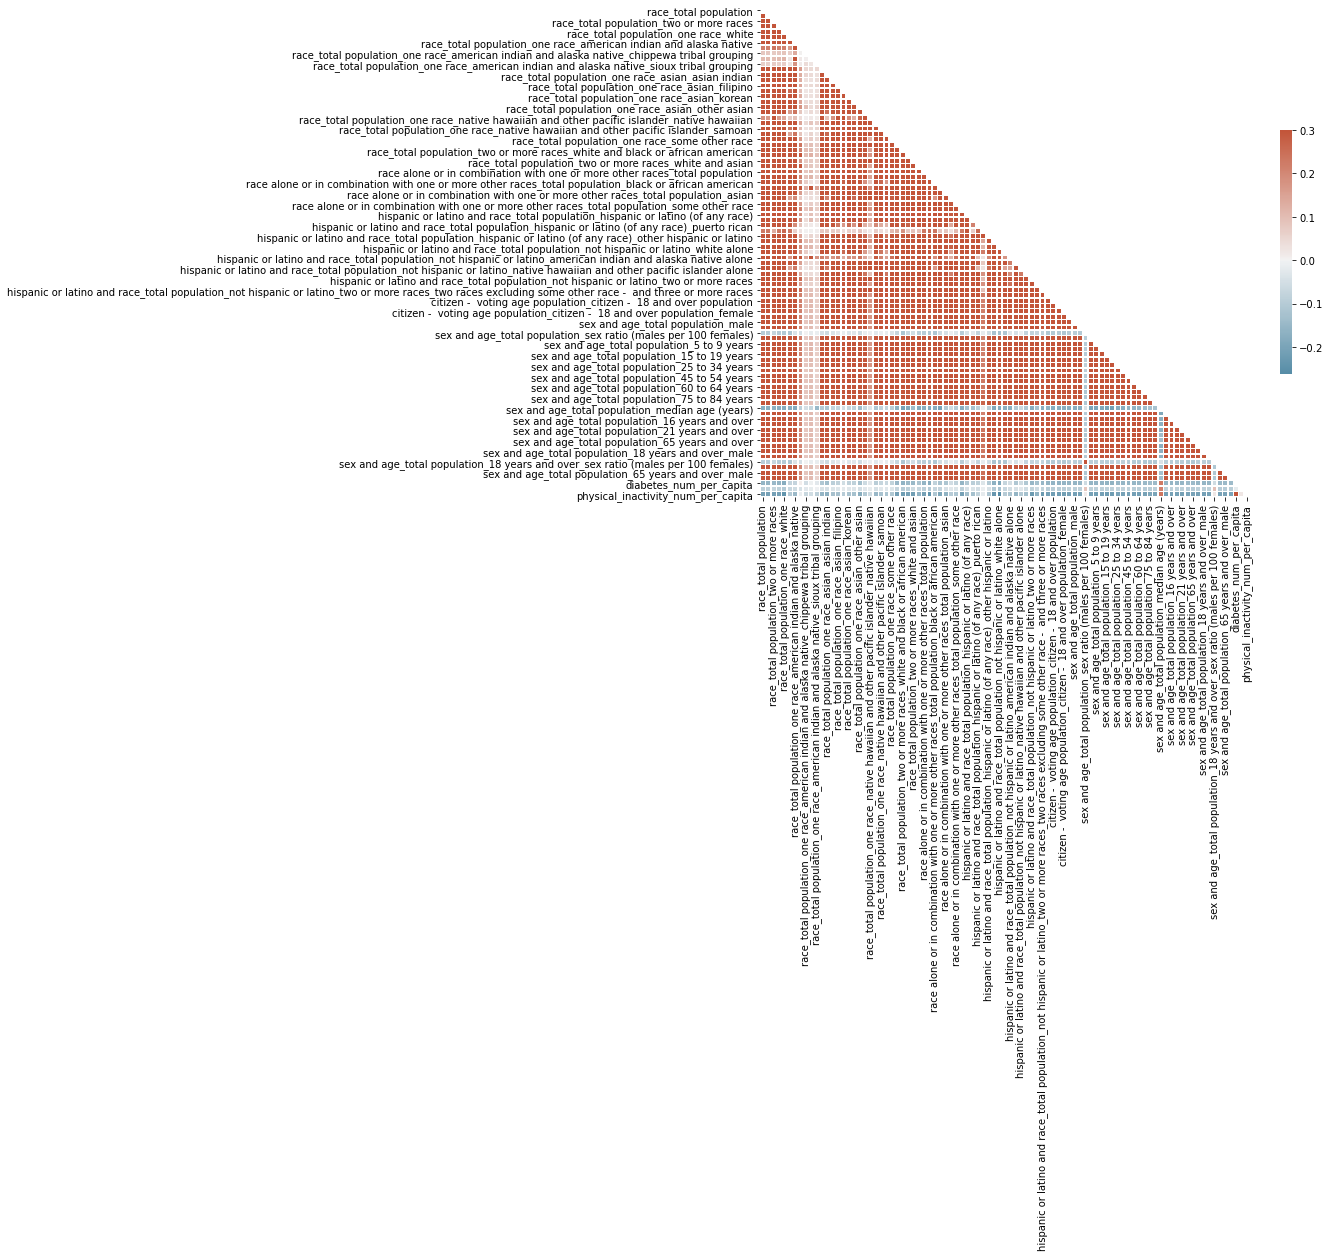

In [8]:
# Compute the correlation matrix
corr = diabetes.drop(['CountyFIPS', 'Diabetes_Number', 'Physical_Inactivity_Number', 'Obesity_Number'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Looks like that made a difference! We should probably scale all of our numerical features by population. 

In [9]:
# 65+ sex ratio had one "-" in it so let's drop that row.
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

In [10]:
# Set index to CountyFIPS, select all numerical (int and float) objects, and divide by total_population
diabetes_clean = diabetes.drop(['County', 
                                'State'], axis = 1).set_index('CountyFIPS').select_dtypes(exclude = ['object']).div(diabetes['race_total population'].values, axis = 0)
diabetes_clean.head()

,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,...,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female,diabetes_num_per_capita,obesity_num_per_capita,physical_inactivity_num_per_capita
CountyFIPS,,,,,,,,,,,,,,,,,,,,,
1001,0.093804,0.244366,0.226902,0.001386,1.0,0.981341,0.018659,0.981341,0.768786,0.191395,...,0.757808,0.363297,0.394511,0.001668,0.145833,0.063188,0.082645,1.699354e-06,3.281874e-10,4.110547e-06
1003,0.080281,0.233255,0.192324,0.000416,1.0,0.982836,0.017164,0.982836,0.862662,0.094970,...,0.780512,0.375307,0.405205,0.000445,0.195404,0.090675,0.104730,3.857670e-07,2.309014e-11,9.241599e-07
1005,0.131875,0.310643,0.210651,0.002956,1.0,0.986308,0.013692,0.986308,0.473819,0.475758,...,0.789155,0.423668,0.365488,0.004495,0.179738,0.077729,0.102009,5.115001e-06,1.504412e-09,8.170462e-06
1007,0.105251,0.290052,0.258667,0.003573,1.0,0.991699,0.008301,0.991699,0.766547,0.222755,...,0.793182,0.425179,0.368003,0.005127,0.162516,0.072491,0.090025,4.672237e-06,1.970576e-09,1.148255e-05
1009,0.108977,0.246804,0.249198,0.001383,1.0,0.983780,0.016220,0.983780,0.955052,0.014954,...,0.766363,0.374621,0.391743,0.001658,0.177518,0.078758,0.098760,1.890491e-06,3.009378e-10,4.322971e-06


## 2.3 Histogram of Diabetes Incidents

Now that we've scaled everything to population, let's take a look at Diabetes_Number to see its distribution.

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]),
 <a list of 6 Text major ticklabel objects>)

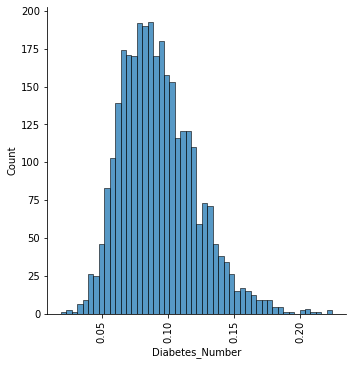

In [11]:
sns.displot(diabetes_clean, x="Diabetes_Number", bins = 50)
plt.xticks(rotation = 90)

It seems close to normally distributed! There's a little bit of a right skew with some particularly high values though.

## 3. Prepare to Fit Models

### 3.1 Clean Data

We've already cleaned up the data during the exploratory phase, but we can make a few more adjustments before partitioning the data and training models. First, let's drop our "per_capita" columns we created during EDA since we've transformed these already.

In [12]:
# Drop diabetes_number, obesity_number, physical_inactivity_number
diabetes_clean.drop(columns = ['diabetes_num_per_capita',
                               'obesity_num_per_capita',
                               'physical_inactivity_num_per_capita'], inplace = True)

### 3.2/3.3 Partition Data and Feature Selection

Now, we will partition our data to prepare it for the training process. We will use 60% train/20% validation/20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

In [13]:
from sklearn.model_selection import train_test_split

# set the random seed
np.random.seed(10)

# Set y (diabetes_num_per_capita)
y = diabetes_clean['Diabetes_Number']

# X (everything except diabetes_num_per_capita)
X = diabetes_clean.drop(columns = ['Diabetes_Number'])

We should also preprocess our data. Using the `preprocessing` module from sklearn, let's scale our features so that they are mean-centered.

In [14]:
from sklearn import preprocessing

X = preprocessing.scale(X)

We can also get rid of the 0 variance features using the `VarianceThreshold()` method from `feature_selection`. This should eliminate features like "race_total population" where all of the observations are equal to 1 (since we divided that column by itself).

In [15]:
from sklearn import feature_selection

# Use a variance threshold of .8
selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X)

And finally, let's split our data:

In [16]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                           train_size = .75, test_size = .25)

## 4 Train Models

First, let's take import all of the libraries that we'll need.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression, OrthogonalMatchingPursuit
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Let's initialize some lists so that we can populate a dataframe later with all of our metrics.

In [18]:
models = ['ols', 'ridge', 'lasso', 'omp', 'dtr']
parameters = []
cv_r2 = []
validation_r2 = []
validation_rmse = []
trained_models = []
accurate = []
recall = []
precision = []
f1_score = []

### Ordinary Least Squares Regression

OLS Regression is a basic linear model that fits the data by minimizing the sum of squared errors between predicted and observed values. It is a good starting point because this is a regression problem (predicting "Diabetes_Number"), and provides the "Beat Linear Unbiased Estimate" (BLUE). However, because it only fits a linear model, this can create some inflexibility and may not generalize well.

In [19]:
# Define our RMSE metric that we will use to measure model performance
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [20]:
# Initialize the model
lin_reg = LinearRegression()

# Set a parameter grid to tune
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}

# Perform GridSearch CV to hyperparameter tune
lin_grid_reg = GridSearchCV(lin_reg, param_grid, cv=3)
lin_grid_reg.fit(X_train, y_train)

# Use the best model to make predictions
best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

# Append the parameters, cv r2, validation r2, and validation RMSE to our lists
parameters.append(lin_grid_reg.cv_results_['params'][best_index])
cv_r2.append(max(lin_grid_reg.cv_results_["mean_test_score"]))
validation_r2.append(lin_grid_reg.score(X_validate, y_validate))
validation_rmse.append(rmse(best_lin_pred, y_validate))

### Ridge Regression

Ridge is in an extension of OLS that introduces a "L1 penalty" that penalizes large coefficients. It will shrink certain coefficients close to 0, and is a good choice for dealing with multicollinearity.

In [21]:
ridge_reg = Ridge() 

param_grid = {'alpha': np.arange(.1, 1, .1),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)
ridge_grid_reg.fit(X_train, y_train)

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)

parameters.append(ridge_grid_reg.cv_results_['params'][best_index])
cv_r2.append(max(ridge_grid_reg.cv_results_["mean_test_score"]))
validation_r2.append(ridge_grid_reg.score(X_validate, y_validate))
validation_rmse.append(rmse(best_ridge_pred, y_validate))

### LASSO

LASSO is similar to Ridge but introduces a L2 penalty which uses absolute values to penalize large coefficients. This allows for automatic feature selection because some coefficients can drop to 0 and thus reduce overall model complexity.

In [22]:
lasso_reg = Lasso(max_iter=10000)  

param_grid = {'alpha': np.arange(.1, 1, .1),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'selection': ['cyclic', 'random']}

lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)
lasso_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)

parameters.append(lasso_grid_reg.cv_results_['params'][best_index])
cv_r2.append(max(lasso_grid_reg.cv_results_["mean_test_score"]))
validation_r2.append(lasso_grid_reg.score(X_validate, y_validate))
validation_rmse.append(rmse(best_lasso_pred, y_validate))

### Orthogonal Matching Pursuit

Orthogonal Matching Pursuit is an algorithm that originates from physics and works by iteratively searching for the combination of columns most likely associated with the current residuals. The advantage of this method is that it is especially good at dealing with hard cases in noisy data.

In [23]:
omp_reg = OrthogonalMatchingPursuit()

param_grid = {'fit_intercept': [True, False],
             'precompute': [True, False]}

omp_grid_reg = GridSearchCV(omp_reg, param_grid, cv = 3)
omp_grid_reg.fit(X_train, y_train)

best_index = np.argmax(omp_grid_reg.cv_results_["mean_test_score"])
best_omp_pred = omp_grid_reg.best_estimator_.predict(X_validate)

parameters.append(omp_grid_reg.cv_results_['params'][best_index])
cv_r2.append(max(omp_grid_reg.cv_results_["mean_test_score"]))
validation_r2.append(omp_grid_reg.score(X_validate, y_validate))
validation_rmse.append(rmse(best_omp_pred, y_validate))

### Decision Tree Regressor

A decision tree makes predictions based on a series of if-then conditions. The standard case for a decision tree is a binary classification, but this model can be extended to regression. Decision trees are good because they allow for non-linear modeling, but can also suffer from too overfitting on the train set easily. Techniques like "pruning" the tree and using ensembles like random forest can help.

In [24]:
dt_reg = DecisionTreeRegressor()

param_grid = {'criterion': ['mse', 'mae'],
             'max_depth': [5, 10, 1],
             'max_features': [10, 50, 10],
             'random_state': [10]}

dt_grid_reg = GridSearchCV(dt_reg, param_grid, cv = 3)
dt_grid_reg.fit(X_train, y_train)

best_index = np.argmax(dt_grid_reg.cv_results_['mean_test_score'])
best_rt_pred = dt_grid_reg.best_estimator_.predict(X_validate)

parameters.append(dt_grid_reg.cv_results_['params'][best_index])
cv_r2.append(max(dt_grid_reg.cv_results_["mean_test_score"]))
validation_r2.append(dt_grid_reg.score(X_validate, y_validate))
validation_rmse.append(rmse(best_rt_pred, y_validate))

### Bonus: Writing More Efficient Code

We can also collapse the above steps into more efficient code. Anytime you find yourself writing the same code over and over again, use tools like functions, for loops, and apply methods to write code more efficiently. First, let's define a function and then test it out:

In [25]:
def hypertune_evaluate_model(model_name, parameter_grid):
    models.append(model_name)
    model_reg = model_name

    param_grid = parameter_grid

    model_grid_reg = GridSearchCV(model_reg, param_grid, cv = 3)
    model_grid_reg.fit(X_train, y_train)

    best_index = np.argmax(model_grid_reg.cv_results_['mean_test_score'])
    best_pred = model_grid_reg.best_estimator_.predict(X_validate)

    parameters.append(model_grid_reg.cv_results_['params'][best_index])
    cv_r2.append(max(model_grid_reg.cv_results_["mean_test_score"]))
    validation_r2.append(model_grid_reg.score(X_validate, y_validate))
    validation_rmse.append(rmse(best_pred, y_validate))
    trained_models.append(model_grid_reg.best_estimator_)
    
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}
hypertune_evaluate_model(LinearRegression(), parameter_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']})

Now let's make two lists for the models we'll test and the hyperparameter grids we'll pass through. Then let's create empty lists for parameters, r^2, validation r^2, and validation RMSE:

In [26]:
models = [LinearRegression(), Ridge(), Lasso(max_iter=10000), OrthogonalMatchingPursuit(), DecisionTreeRegressor()]
parameter_grids = [{'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']},
                  {'alpha': np.arange(.1, 1, .1),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'solver': ['auto', 'svd', 'cholesky', 'lsqr']},
                   {'alpha': np.arange(.1, 1, .1),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'selection': ['cyclic', 'random']},
                  {'fit_intercept': [True, False],
             'precompute': [True, False]},
                  {'criterion': ['mse', 'mae'],
             'max_depth': [5, 10, 1],
             'max_features': [10, 50, 10],
             'random_state': [10]}]
parameters = []
cv_r2 = []
validation_r2 = []
validation_rmse = []
trained_models = []

Now, let's loop through both lists and evaluate the function. Notice that we can do this with just two lines of code!

In [27]:
for model, grid in zip(models, parameter_grids):
    hypertune_evaluate_model(model, grid)

And finally, we can put these lists together into a dataframe and see how our various models did:

In [28]:
data_tuples = list(zip(models,parameter_grids, parameters, cv_r2, validation_r2, validation_rmse, trained_models))
models_df = pd.DataFrame(data_tuples, columns=['Model', 'Grid_Search', 'Parameters', "CV_R2", "Validation_R2", "Validation_RMSE", "Trained_Model"])
models_df.head()

,Model,Grid_Search,Parameters,CV_R2,Validation_R2,Validation_RMSE,Trained_Model
0,LinearRegression(),"{'fit_intercept': ['True', 'False'], 'normaliz...","{'fit_intercept': 'True', 'normalize': 'True'}",0.449589,0.446726,0.019359,"LinearRegression(fit_intercept='True', normali..."
1,Ridge(),"{'alpha': [0.1, 0.2, 0.30000000000000004, 0.4,...","{'alpha': 0.1, 'fit_intercept': 'True', 'norma...",0.498220,0.448509,0.019327,"Ridge(alpha=0.1, fit_intercept='True', normali..."
2,Lasso(max_iter=10000),"{'alpha': [0.1, 0.2, 0.30000000000000004, 0.4,...","{'alpha': 0.1, 'fit_intercept': 'True', 'norma...",-0.000409,-0.006166,0.026106,"Lasso(alpha=0.1, fit_intercept='True', max_ite..."
3,OrthogonalMatchingPursuit(),"{'fit_intercept': [True, False], 'precompute':...","{'fit_intercept': True, 'precompute': True}",0.489754,0.448166,0.019333,OrthogonalMatchingPursuit(precompute=True)
4,DecisionTreeRegressor(),"{'criterion': ['mse', 'mae'], 'max_depth': [5,...","{'criterion': 'mae', 'max_depth': 5, 'max_feat...",0.323017,0.332444,0.021264,"DecisionTreeRegressor(criterion='mae', max_dep..."


Notice how powerful data structures are here. Our lists were able to store strings, dictionaries, floats, and even sklearn model objects! We were then able to turn all of these into a dataframe where we can easily check out the differences between our models. Let's see which model got our best Validation RMSE using `idxmin()`

In [29]:
models_df.loc[models_df['Validation_RMSE'].idxmin()]

Model                                                        Ridge()
Grid_Search        {'alpha': [0.1, 0.2, 0.30000000000000004, 0.4,...
Parameters         {'alpha': 0.1, 'fit_intercept': 'True', 'norma...
CV_R2                                                        0.49822
Validation_R2                                               0.448509
Validation_RMSE                                            0.0193274
Trained_Model      Ridge(alpha=0.1, fit_intercept='True', normali...
Name: 1, dtype: object

It looks like our Ridge model did best! 

### Feature Selection

Let's take a look at our top 10 coefficients to see if tjere are certaom features that are highly predictive. It looks like "65 and over" is duplicated, and there's a drop off after about 10 features or so. Let's retrain our models with the most important features before moving on to our test set.

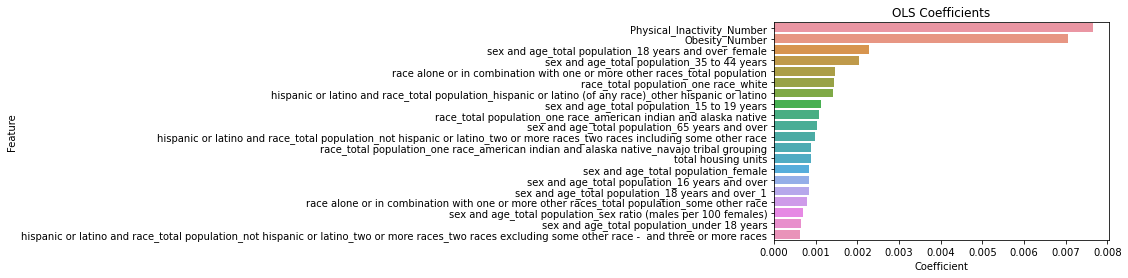

In [30]:
ridge_reg_data = pd.DataFrame([models_df['Trained_Model'][1].fit(X_train, y_train).coef_, 
                               diabetes_clean.drop(columns = ['Diabetes_Number']).columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']
ridge_reg_data.replace(to_replace=[None], value= 0, inplace=True)
ridge_reg_data['Coefficient'] = ridge_reg_data['Coefficient'].astype(float)

ax = sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data.nlargest(20, "Coefficient"))
ax.set_title("OLS Coefficients")
plt.show()

In [31]:
top_ridge_features = list(ridge_reg_data.nlargest(20, 'Coefficient')['Feature'])
X_train = pd.DataFrame(X_train, columns = diabetes_clean.drop(columns = 
                                                    ['Diabetes_Number']).loc[:, selector.get_support()].columns).filter(top_ridge_features, axis = 1)

X_validate = pd.DataFrame(X_validate, columns = diabetes_clean.drop(columns = 
                                                    ['Diabetes_Number']).loc[:, selector.get_support()].columns).filter(top_ridge_features, axis = 1)

X_test = pd.DataFrame(X_test, columns = diabetes_clean.drop(columns = 
                                                    ['Diabetes_Number']).loc[:, selector.get_support()].columns).filter(top_ridge_features, axis = 1)

In [32]:
import warnings
warnings.filterwarnings(action='ignore')

parameters = []
cv_r2 = []
validation_r2 = []
validation_rmse = []
trained_models = []

for model, grid in zip(models, parameter_grids):
    hypertune_evaluate_model(model, grid)

data_tuples = list(zip(models,parameter_grids, parameters, cv_r2, validation_r2, validation_rmse, trained_models))
models_df = pd.DataFrame(data_tuples, columns=['Model', 'Grid_Search', 'Parameters', "CV_R2", "Validation_R2", "Validation_RMSE", "Trained_Model"])
models_df.head(10)

,Model,Grid_Search,Parameters,CV_R2,Validation_R2,Validation_RMSE,Trained_Model
0,LinearRegression(),"{'fit_intercept': ['True', 'False'], 'normaliz...","{'fit_intercept': 'True', 'normalize': 'True'}",0.467058,0.423184,0.019766,"LinearRegression(fit_intercept='True', normali..."
1,Ridge(),"{'alpha': [0.1, 0.2, 0.30000000000000004, 0.4,...","{'alpha': 0.1, 'fit_intercept': 'True', 'norma...",0.479462,0.428203,0.019680,"Ridge(alpha=0.1, fit_intercept='True', normali..."
2,Lasso(max_iter=10000),"{'alpha': [0.1, 0.2, 0.30000000000000004, 0.4,...","{'alpha': 0.1, 'fit_intercept': 'True', 'norma...",-0.000409,-0.006166,0.026106,"Lasso(alpha=0.1, fit_intercept='True', max_ite..."
3,OrthogonalMatchingPursuit(),"{'fit_intercept': [True, False], 'precompute':...","{'fit_intercept': True, 'precompute': True}",0.350605,0.318746,0.021481,OrthogonalMatchingPursuit(precompute=True)
4,DecisionTreeRegressor(),"{'criterion': ['mse', 'mae'], 'max_depth': [5,...","{'criterion': 'mse', 'max_depth': 5, 'max_feat...",0.343918,0.288247,0.021957,"DecisionTreeRegressor(max_depth=5, max_feature..."


Looks like we got comparable performance with many fewer features! We'll continue on with our Ridge model.

### Test Set

In [33]:
test_pred = models_df['Trained_Model'][1].predict(X_test)
print('Test RMSE is', rmse(test_pred, y_validate))

Test RMSE is 0.03217931406974061


Pretty similar to what we were seeing in our validation set! The advantage of using the validation set is that it allowed us to retrain models based on what we saw in the validation process, but still keep the test set held out and untouched until the very final prediction. This way, we are not overfitting on the test outcomes.

## Cross-Validation

We'll conclude by repeating our model training with cross-validation. Cross-validation has the advantage of allowing every data point to be in both the training and testing sets, and it tends to avoid overfitting better than a traditional train/test split. The main choice with cross-validation involves the choice of "k" or the number of folds. More folds lower increase variance, and will be more computationally intensive.

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [35]:
preds = cross_val_predict(models_df['Trained_Model'][1], X, y, cv = 5)
print(rmse(preds, y))

0.02092809681953464


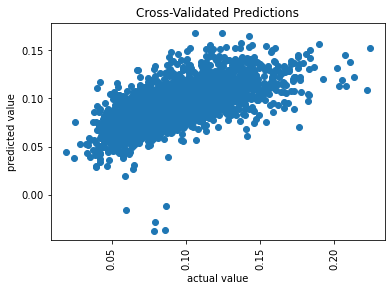

In [36]:
# plot the residuals on a scatter plot
plt.scatter(y, preds)
plt.title('Cross-Validated Predictions')
plt.xticks(rotation = 90)
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

Our cross-validated predictions seemed to do fairly well! There is a clear positive trend, though there are some outliers. The RMSE is comparable to our best models from the train/validation/test process as well.